# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Ashwini | Nair | AN | 6 | 25% |
| Member 2: | Dhruv | Jingar | DJ | 6 | 25% |
| Member 3: | Ravi Deepak | Dave | RDD | 6 | 25% |
| Member 4: | Yash | Mistry | YM | 6 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

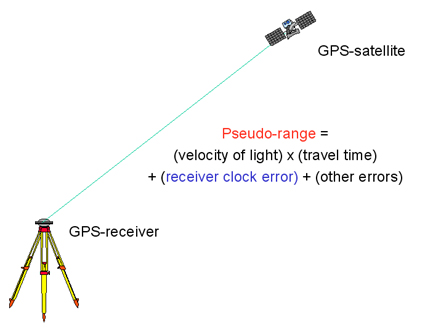

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [84]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/LabAssignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/LabAssignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [85]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [86]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [87]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [88]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    n = pseudorange.size

# Calculate the geometric distance using the euclidean_norm function
    geometric_distance = euclidean_norm(r_pos, s_pos)

# Predicted pseudorange including the clock bias
    predicted_pseudorange = geometric_distance + cdT

# Calculate the residuals
    residuals = pseudorange - predicted_pseudorange

# Calculate the cost as the mean of squared residuals
    cost = (1 / n) * np.sum(residuals ** 2)
    return cost

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [89]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

# Calculate geometric distance (array of distances) using the euclidean_norm function
    geometric_distance = euclidean_norm(r_pos, s_pos)

# Predicted pseudorange including clock offset
    predicted_pseudorange = geometric_distance + cdT

# Calculate residuals
    residuals = pseudorange - predicted_pseudorange

# Number of satellites
    n = pseudorange.size

# Compute gradients with respect to x_r, y_r, z_r, and cdT
    grad_x_r = (-2 / n) * np.sum(residuals * (r_pos[0] - s_pos[:, 0]) / geometric_distance)
    grad_y_r = (-2 / n) * np.sum(residuals * (r_pos[1] - s_pos[:, 1]) / geometric_distance)
    grad_z_r = (-2 / n) * np.sum(residuals * (r_pos[2] - s_pos[:, 2]) / geometric_distance)
    grad_cdT = (-2 / n) * np.sum(residuals)  # No need to divide by geometric_distance for cdT

    # Combine all gradients into a 1D numpy array
    grad = np.array([grad_x_r, grad_y_r, grad_z_r, grad_cdT])

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [90]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0.0,0.0,0.0,0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X, arr_cost, arr_grad, arr_err

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [91]:
optimized_params, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos)
final_position_errors = arr_err[-1]
final_cost = arr_cost[-1]
final_gradient = arr_grad[-1]

# print the mentioned metrics
print("Optimized Parameters:", optimized_params)
print("Final Position Errors:", final_position_errors)
print("Number of Steps:", steps_count)
print("Final Cost:", final_cost)
print("Final Gradient:", final_gradient)

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248530e+06  6.39730403e+00]
Final Position Errors: [-3.05714443 -2.31699848  3.68137918]
Number of Steps: 27900
Final Cost: 0.5641548583233607
Final Gradient: [ 0.00048857  0.00272232 -0.00836683 -0.0047434 ]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

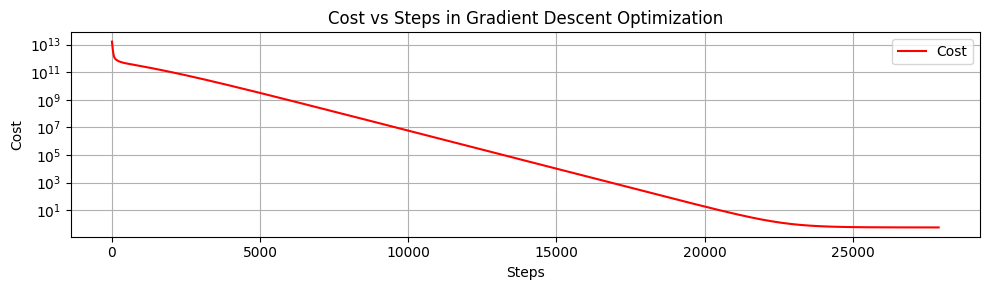

In [92]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost, linestyle='-', color='red', label = "Cost")
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps in Gradient Descent Optimization')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern
# The cost plateaus, which means that the model has found an optimal solution.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

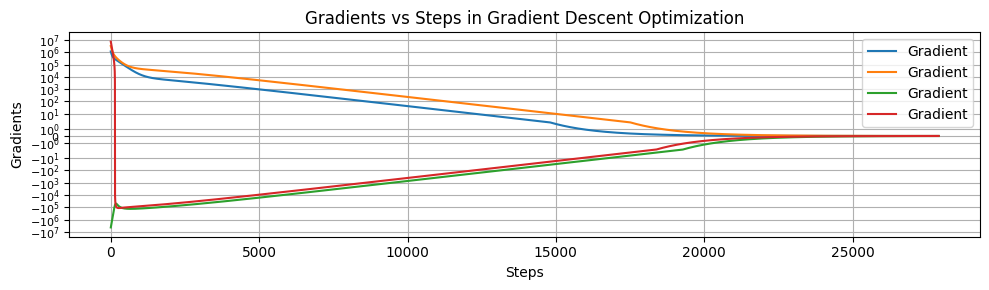

In [93]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(arr_grad, linestyle='-', label ="Gradient")
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
ax.set_title('Gradients vs Steps in Gradient Descent Optimization')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern
# Answer
# Steep Initial Decrease: The gradient norm typically decreases rapidly in the initial steps,
# indicating that the algorithm is making large updates to the parameters as it moves toward the
# minimum of the cost function.
# Flattening of Gradient Norm: As the algorithm approaches an optimal solution, the gradient norm
# values become smaller and may plateau. This pattern shows that the updates to the parameters are getting smaller, indicating convergence.
# Possible Oscillations: Near the end, the gradient norm may oscillate around small values,
#reflecting minor adjustments in the parameters as the solution converges. This is typical in gradient
# descent as it fine-tunes around the optimal solution.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

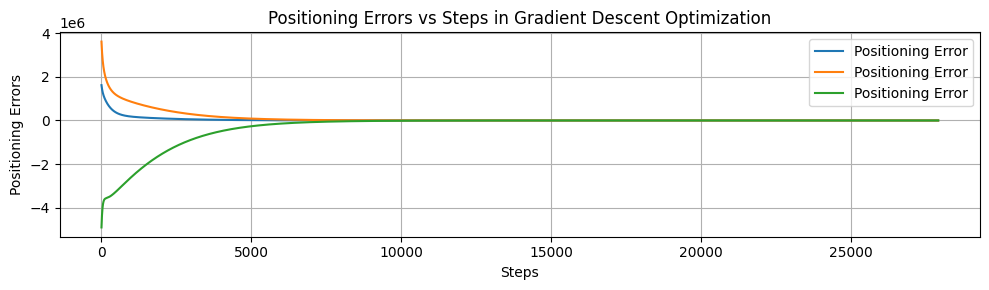

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err, linestyle='-', label = "Positioning Error")
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors')
ax.set_title('Positioning Errors vs Steps in Gradient Descent Optimization')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern
# Initial Sharp Drop: In the first few iterations, the positioning error should decrease rapidly, reflecting the algorithm’s quick adjustments toward a closer estimate of the receiver’s true position.
# Gradual Flattening: As the algorithm gets closer to the optimal position, the error decrease becomes more gradual, and the curve starts to flatten. This is typical in gradient descent as the updates become smaller near the minimum.
# Possible Small Oscillations: Near the end, you may see minor oscillations around a low error value, indicating that the estimate is converging and the positioning error is close to its minimum.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [112]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos,0.01)
final_position_errors = arr_err[-1]
final_cost = arr_cost[-1]
final_gradient = arr_grad[-1]
# print the metrics
print("Optimized Parameters:", optimized_params_2)
print("Final Position Errors:", final_position_errors)
print("Number of Steps:", steps_count)
print("Final Cost:", final_cost)
print("Final Gradient:", final_gradient)

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248530e+06  6.39730403e+00]
Final Position Errors: [-3.05714443 -2.31699848  3.68137918]
Number of Steps: 27900
Final Cost: 0.5641548583233607
Final Gradient: [ 0.00048857  0.00272232 -0.00836683 -0.0047434 ]


In [114]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
learning_rate=0.001

optimized_params_3, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos,0.001)

# print the metrics
print("Optimized Parameters:", optimized_params_3)
print("Final Position Errors:", final_position_errors)
print("Number of Steps:", steps_count)
print("Final Cost:", final_cost)
print("Final Gradient:", final_gradient)

Optimized Parameters: [-1632830.55070343 -3647942.8284674   4941155.20410916    -6419.0317058 ]
Final Position Errors: [-3.05714443 -2.31699848  3.68137918]
Number of Steps: 0
Final Cost: 0.5641548583233607
Final Gradient: [ 0.00048857  0.00272232 -0.00836683 -0.0047434 ]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Answer1:
After changing the learning rate, the value of output decreases which means that the output is becoming more accurate with less learning rate.

Answer 2:
LSE is mainly used for estimating parameters of a linear model, while Gradient Descent is an optimization algorithm.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [98]:
!pip install ucimlrepo

In [99]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets
#convert to dataframe
x = pd.DataFrame(X, columns = phishing_websites.metadata.feature_names)
y = pd.DataFrame(y, columns = phishing_websites.metadata.target_names)
# TO DO: display sizes of X and y (1 mark)
print("Size of X:", x.shape)
print("Size of y:", y.shape)


Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [100]:
!pip install seaborn

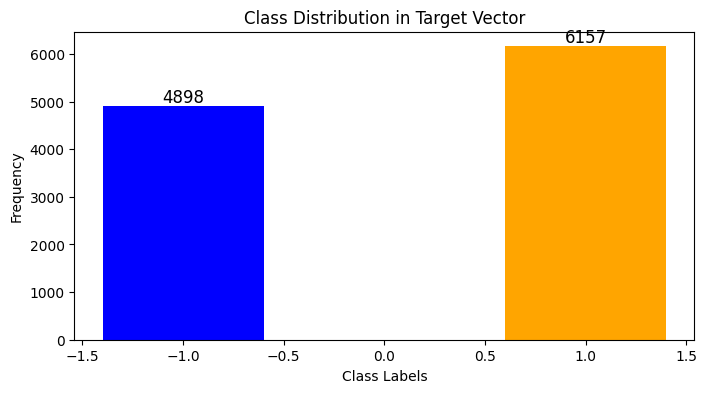

In [101]:
# TO DO: Check the class distribution of y (2 mark)
# Count the unique values and their frequencies in y
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plot the histogram for each class label
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])

# Add exact values above each bar
for i, count in zip(class_counts.keys(), class_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

# Set plot labels and title
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution in Target Vector")

# Display the plot
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [102]:
from sklearn.model_selection import train_test_split
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print(f"Size of X_small: {X_small.shape}")
print(f"Size of y_small: {y_small.shape}")

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [103]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Step 3
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score\

#Instantiate model LogisticRegression(max_iter=2000)
model_full = LogisticRegression(max_iter=2000)
y = y.values.ravel()  # Converts the target to a 1D array (if it's a 2D column vector
#Train (fit) the model on the full dataset
model_full.fit(X, y.ravel())

#Train the model on the full dataset

y_pred_full = model_full.predict(X)
accuracy_full = accuracy_score(y, y_pred_full)
print(f"Accuracy with full dataset: {accuracy_full:.2f}")

# Ensure y_small is a 1D array by converting it to a numpy array and then flattening it
y_small = np.array(y_small).ravel()
# Instantiate and train (fit) the model on the smaller dataset
model_small = LogisticRegression(max_iter=2000)
model_small.fit(X_small, y_small)

y_pred_small = model_small.predict(X_small)
accuracy_small = accuracy_score(y_small, y_pred_small)
print(f"Accuracy with smaller dataset: {accuracy_small:.2f}")


#Step 4

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Function to train and evaluate the model
def train_and_evaluate(X, y, random_state=0):
    # Split the data into training and testing sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    # Initialize the Logistic Regression model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    loss = log_loss(y_test, y_test_proba)

    return {
        "Data Size": X.shape[0],
        "Training Samples": X_train.shape[0],
        "Testing Samples": X_test.shape[0],
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": loss  # Ensure that the key is clean
    }

# Assuming X and y are already defined (e.g., from pandas DataFrame)

# 1. Full Dataset (X and y)
results_full = train_and_evaluate(X, y)

# 2. First Two Columns of X and y
X_two_columns = X.iloc[:, :2]  # Already handles pandas input
results_two_columns = train_and_evaluate(X_two_columns, y)

# 3. Smaller Dataset (X_small and y_small)
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
results_small = train_and_evaluate(X_small, y_small)


# Print the results for Step 4
print("Results for Full Dataset:")
print(f"Data Size: {results_full['Data Size']}")
print(f"Number of Training Samples: {results_full['Training Samples']}")
print(f"Number of Testing Samples: {results_full['Testing Samples']}")
print(f"Training Accuracy: {results_full['Training Accuracy']:.2f}")
print(f"Testing Accuracy: {results_full['Testing Accuracy']:.2f}")
print(f"Log Loss: {results_full['Log Loss']:.2f}\n")

print("Results for First Two Columns of X:")
print(f"Data Size: {results_two_columns['Data Size']}")
print(f"Number of Training Samples: {results_two_columns['Training Samples']}")
print(f"Number of Testing Samples: {results_two_columns['Testing Samples']}")
print(f"Training Accuracy: {results_two_columns['Training Accuracy']:.2f}")
print(f"Testing Accuracy: {results_two_columns['Testing Accuracy']:.2f}")
print(f"Log Loss: {results_two_columns['Log Loss']:.2f}\n")

print("Results for Smaller Dataset:")
print(f"Data Size: {results_small['Data Size']}")
print(f"Number of Training Samples: {results_small['Training Samples']}")
print(f"Number of Testing Samples: {results_small['Testing Samples']}")
print(f"Training Accuracy: {results_small['Training Accuracy']:.2f}")
print(f"Testing Accuracy: {results_small['Testing Accuracy']:.2f}")
print(f"Log Loss: {results_small['Log Loss']:.2f}\n")



# Step 5.1
def train_and_evaluate(X, y, random_state=0):
    # Split the data into training and testing sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    # Initialize the Logistic Regression model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    loss = log_loss(y_test, y_test_proba)

    return {
        "Data Size": X.shape[0],
        "Training Samples": X_train.shape[0],
        "Testing Samples": X_test.shape[0],
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": loss
    }


# 1. Full Dataset (X and y)
results_full = train_and_evaluate(X, y)

# 2. First Two Columns of X and y
X_two_columns = X.iloc[:, :2]
results_two_columns = train_and_evaluate(X_two_columns, y)

# 3. Smaller Dataset (X_small and y_small)
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
results_small = train_and_evaluate(X_small, y_small)

# Step 5.1: Create Results DataFrame and Print Results
results = pd.DataFrame({
    "Dataset": ["Full Dataset", "First Two Columns", "Smaller Dataset"],
    "Data Size": [results_full["Data Size"], results_two_columns["Data Size"], results_small["Data Size"]],
    "Training Samples": [results_full["Training Samples"], results_two_columns["Training Samples"], results_small["Training Samples"]],
    "Testing Samples": [results_full["Testing Samples"], results_two_columns["Testing Samples"], results_small["Testing Samples"]],
    "Training Accuracy": [results_full["Training Accuracy"], results_two_columns["Training Accuracy"], results_small["Training Accuracy"]],
    "Testing Accuracy": [results_full["Testing Accuracy"], results_two_columns["Testing Accuracy"], results_small["Testing Accuracy"]],
    "Log Loss": [results_full["Log Loss"], results_two_columns["Log Loss"], results_small["Log Loss"]]
})

# Print the results DataFrame
print(results)

Accuracy with full dataset: 0.93
Accuracy with smaller dataset: 0.95
Results for Full Dataset:
Data Size: 11055
Number of Training Samples: 7738
Number of Testing Samples: 3317
Training Accuracy: 0.93
Testing Accuracy: 0.92
Log Loss: 0.19

Results for First Two Columns of X:
Data Size: 11055
Number of Training Samples: 7738
Number of Testing Samples: 3317
Training Accuracy: 0.56
Testing Accuracy: 0.56
Log Loss: 0.68

Results for Smaller Dataset:
Data Size: 331
Number of Training Samples: 231
Number of Testing Samples: 100
Training Accuracy: 0.94
Testing Accuracy: 0.91
Log Loss: 0.20

             Dataset  Data Size  Training Samples  Testing Samples  \
0       Full Dataset      11055              7738             3317   
1  First Two Columns      11055              7738             3317   
2    Smaller Dataset        331               231              100   

   Training Accuracy  Testing Accuracy  Log Loss  
0           0.932282          0.922822  0.190326  
1           0.562807      

### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [104]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
# Split the full dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=2000)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)  # For log loss calculation.

# Print the dimensions of the predicted output
print(f"Dimensions of the predicted output: {y_test_pred.shape}")

# Print the target vector and predicted values
print("Target vector (y_test):")
print(y_test)
print("Predicted values (y_test_pred):")
print(y_test_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Dimensions of the predicted output: (3317,)
Target vector (y_test):
[-1 -1 -1 ... -1  1  1]
Predicted values (y_test_pred):
[-1 -1  1 ... -1  1  1]
Confusion Matrix:
[[1341  157]
 [  99 1720]]


Confusion Matrix:
[[1341  157]
 [  99 1720]]


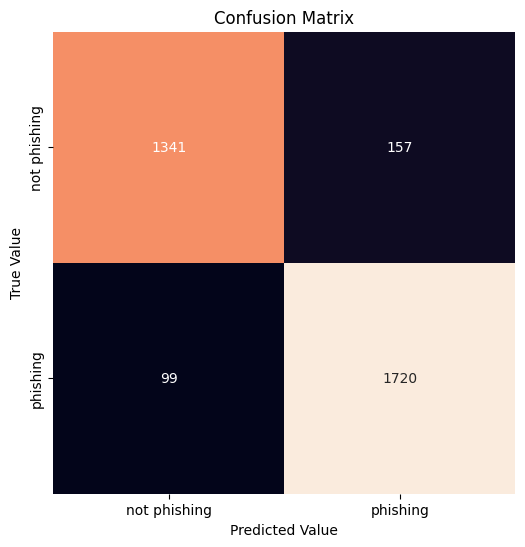

In [105]:
# Split the full dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Split the full dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=2000)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Plot the confusion matrix using a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'], yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d', ax=ax)
ax.set_xlabel('Predicted Value')
ax.set_ylabel('True Value')
ax.set_title('Confusion Matrix')

# Display the plot
plt.show()


Text(113.9222222222222, 0.5, 'true value')

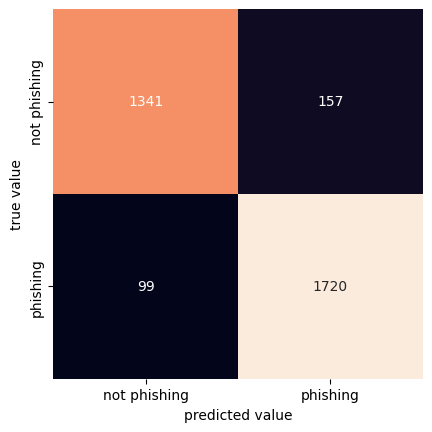

In [108]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [107]:
# TO DO: Print classification report (2 marks)
# Print the classification report
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---

Answer 1: Indeed, the data is unbalanced. An unbalanced dataset may favour the dominant class, which could cause the model to overlook minority classes and produce a large number of false negatives.

Answer 2: Case 1 (X, y) Case 2: X and Y, the first two columns Case 3 (X_small and y_small): This model is underfitting because of the high log loss. Reducing the amount of the data set will eliminate unnecessary complexity.

Answer 3: The quantity of data has an impact on both training and testing accuracy. Both training and testing accuracy increase with the amount of accessible training data.On the training set, the model will typically be more accurate. However, insufficient training data might result in low or inconsistent testing and training accuracy, which can cause overfitting or underfitting.

Answer 4: When the model predicts a positive class label when it should be negative, this is known as a false positive. When the model predicts a negative class when it should actually belong to the positive class, this is known as a false negative. In this instance, the false negative can be reported by the user and removed, but the false positive would be worse since it might cause crucial emails or information to be missed.

Answer 5: In order to prevent real emails from being marked as spam, we would want to be as precise as possible. To achieve this, we might either select parameters that favour accuracy during the training phase or raise the threshold for categorizing positive cases.

Answer 6: Better model performance, or more accurate predictions, is shown by a lower log loss. The second scenario performs better than the other two since it has a lower log loss.

---